# Whole Slide Image Classification Using PyTorch and TIAToolbox

In [1]:
"""Import modules required to run the Jupyter notebook."""
from __future__ import annotations

# Configure logging
import logging
import warnings
if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

# Downloading data and files
import shutil
from pathlib import Path
from zipfile import ZipFile

# Data processing and visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import PIL
import contextlib
import io
from sklearn.metrics import accuracy_score, confusion_matrix

# TIAToolbox for WSI loading and processing
from tiatoolbox import logger
from tiatoolbox.models.architecture import vanilla
from tiatoolbox.models.engine.patch_predictor import (
    IOPatchPredictorConfig,
    PatchPredictor,
)
from tiatoolbox.utils.misc import download_data, grab_files_from_dir
from tiatoolbox.utils.visualization import overlay_prediction_mask
from tiatoolbox.wsicore.wsireader import WSIReader

# Torch-related
import torch
from torchvision import transforms

# Configure plotting
mpl.rcParams["figure.dpi"] = 160  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

# If you are not using GPU, change ON_GPU to False
ON_GPU = True

# Function to suppress console output for overly verbose code blocks
def suppress_console_output():
    return contextlib.redirect_stderr(io.StringIO())

|2024-12-31|14:39:06.187| [WARNING] /home/lms/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lms/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(



### 달리기 전 정리하기

In [2]:
warnings.filterwarnings("ignore")
global_save_dir = Path("./tmp/")

def rmdir(dir_path: str | Path) -> None:
    if Path(dir_path).is_dir():
        shutil.rmtree(dir_path)
        logger.info("Removing dierctory %s", dir_path)

rmdir(global_save_dir)
global_save_dir.mkdir()
logger.info("Creating new directory %s", global_save_dir)

|2024-12-31|14:39:11.000| [INFO] Removing dierctory tmp
|2024-12-31|14:39:11.002| [INFO] Creating new directory tmp


In [3]:
wsi_path = global_save_dir / "sample_wsi.svs"
patches_path = global_save_dir / "kather100k-validation-sample.zip"
weights_path = global_save_dir / "resnet18-kather100k.pth"

logger.info("Download has started. please wait.....")

download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs",
    wsi_path
)

download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip",
    patches_path,
)
with ZipFile(patches_path, "r") as zipfile:
    zipfile.extractall(path=global_save_dir)

download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/models/pc/resnet18-kather100k.pth",
    weights_path,
)

logger.info("Download is complete.")

|2024-12-31|14:39:11.021| [INFO] Download has started. please wait.....
|2024-12-31|14:42:47.674| [INFO] Download is complete.


|2024-12-31|14:42:47.718| [INFO] Class ID: 0 -- Class Name: BACK -- Number of images: 211
|2024-12-31|14:42:47.719| [INFO] Class ID: 1 -- Class Name: NORM -- Number of images: 176
|2024-12-31|14:42:47.719| [INFO] Class ID: 2 -- Class Name: DEB -- Number of images: 230
|2024-12-31|14:42:47.720| [INFO] Class ID: 3 -- Class Name: TUM -- Number of images: 286
|2024-12-31|14:42:47.720| [INFO] Class ID: 4 -- Class Name: ADI -- Number of images: 208
|2024-12-31|14:42:47.721| [INFO] Class ID: 5 -- Class Name: MUC -- Number of images: 178
|2024-12-31|14:42:47.722| [INFO] Class ID: 6 -- Class Name: MUS -- Number of images: 270
|2024-12-31|14:42:47.722| [INFO] Class ID: 7 -- Class Name: STR -- Number of images: 209
|2024-12-31|14:42:47.723| [INFO] Class ID: 8 -- Class Name: LYM -- Number of images: 232
|2024-12-31|14:42:47.723| [INFO] Total number of patches: 2000


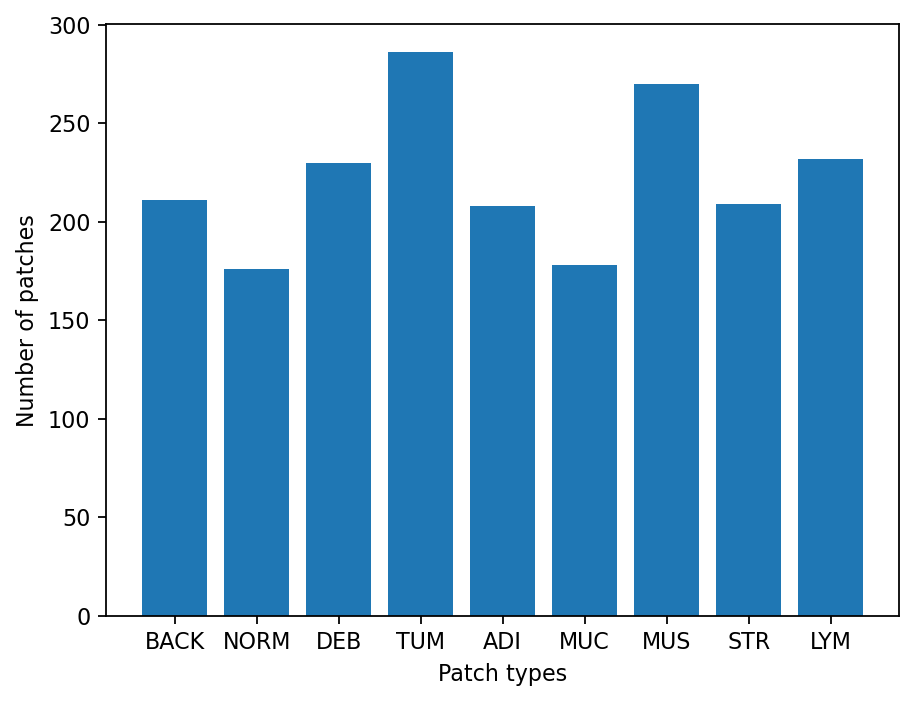

In [4]:
# Read the patch data and create a list of patches and a list of corresponding labels
dataset_path = global_save_dir / "kather100k-validation-sample"

# Set the path to the dataset
image_ext = ".tif"  # file extension of each image

# Obtain the mapping between the label ID and the class name
label_dict = {
    "BACK": 0, # Background (empty glass region)
    "NORM": 1, # Normal colon mucosa
    "DEB": 2,  # Debris
    "TUM": 3,  # Colorectal adenocarcinoma epithelium
    "ADI": 4,  # Adipose
    "MUC": 5,  # Mucus
    "MUS": 6,  # Smooth muscle
    "STR": 7,  # Cancer-associated stroma
    "LYM": 8,  # Lymphocytes
}

class_names = list(label_dict.keys())
class_labels = list(label_dict.values())

# Generate a list of patches and generate the label from the filename
patch_list = []
label_list = []
for class_name, label in label_dict.items():
    dataset_class_path = dataset_path / class_name
    patch_list_single_class = grab_files_from_dir(
        dataset_class_path,
        file_types="*" + image_ext,
    )
    patch_list.extend(patch_list_single_class)
    label_list.extend([label] * len(patch_list_single_class))

# Show some dataset statistics
plt.bar(class_names, [label_list.count(label) for label in class_labels])
plt.xlabel("Patch types")
plt.ylabel("Number of patches")

# Count the number of examples per class
for class_name, label in label_dict.items():
    logger.info(
        "Class ID: %d -- Class Name: %s -- Number of images: %d",
        label,
        class_name,
        label_list.count(label),
    )

# Overall dataset statistics
logger.info("Total number of patches: %d", (len(patch_list)))

### 이미지 패치 분류

In [5]:
# Importing a pretrained PyTorch model from TIAToolbox
predictor = PatchPredictor(pretrained_model='resnet18-kather100k', batch_size=32)

# Users can load any PyTorch model architecture instead using the following script
model = vanilla.CNNModel(backbone="resnet18", num_classes=9) # Importing model from torchvision.models.resnet18
model.load_state_dict(torch.load(weights_path, map_location="cpu"), strict=True)
def preproc_func(img):
    img = PIL.Image.fromarray(img)
    img = transforms.ToTensor()(img)
    return img.permute(1, 2, 0)
model.preproc_func = preproc_func
predictor = PatchPredictor(model=model, batch_size=32)

|2024-12-31|14:42:48.630| [WARNING] GPU is not compatible with torch.compile. Compatible GPUs include NVIDIA V100, A100, and H100. Speedup numbers may be lower than expected.
|2024-12-31|14:42:49.026| [WARNING] GPU is not compatible with torch.compile. Compatible GPUs include NVIDIA V100, A100, and H100. Speedup numbers may be lower than expected.


In [6]:
# Importing a pretrained PyTorch model from TIAToolbox
predictor = PatchPredictor(pretrained_model='resnet18-kather100k', batch_size=32)

# Users can load any PyTorch model architecture instead using the following script
model = vanilla.CNNModel(backbone="resnet18", num_classes=9) # Importing model from torchvision.models.resnet18
model.load_state_dict(torch.load(weights_path, map_location="cpu"), strict=True)
def preproc_func(img):
    img = PIL.Image.fromarray(img)
    img = transforms.ToTensor()(img)
    return img.permute(1, 2, 0)
model.preproc_func = preproc_func
predictor = PatchPredictor(model=model, batch_size=32)

|2024-12-31|14:42:49.499| [WARNING] GPU is not compatible with torch.compile. Compatible GPUs include NVIDIA V100, A100, and H100. Speedup numbers may be lower than expected.
|2024-12-31|14:42:49.953| [WARNING] GPU is not compatible with torch.compile. Compatible GPUs include NVIDIA V100, A100, and H100. Speedup numbers may be lower than expected.


### 패치 라벨 예측

In [7]:
with suppress_console_output():
    output = predictor.predict(imgs=patch_list, mode="patch", on_gpu = ON_GPU)

acc = accuracy_score(label_list, output["predictions"])
logger.info("Classification accuracy: %f", acc)

# Creating and visualizing the confusion matrix for patch classification results
conf = confusion_matrix(label_list, output["predictions"], normalize="true")
df_cm = pd.DataFrame(conf, index=class_names, columns=class_names)
df_cm

TypeError: PatchPredictor.predict() got an unexpected keyword argument 'on_gpu'

In [10]:
wsi_ioconfig = IOPatchPredictorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 0.5}],
    patch_input_shape=[224, 224],
    stride_shape=[224, 224],
)

In [23]:
with suppress_console_output():
    wsi_output = predictor.predict(
        imgs = [wsi_path],
        masks=None,
        mode="wsi",
        merge_predictions=False,
        ioconfig=wsi_ioconfig,
        return_probabilities=True,
        save_dir=global_save_dir / "wsi_predictions",
        on_gpu = ON_GPU
    )

TypeError: PatchPredictor.predict() got an unexpected keyword argument 'on_gpu'

In [ ]:
overview_resolution = (
    4  # the resolution in which we desire to merge and visualize the patch predictions
)
# the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"
overview_unit = "mpp"
wsi = WSIReader.open(wsi_path)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)
plt.figure(), plt.imshow(wsi_overview)
plt.axis("off")

In [5]:
# Import some extra modules
from timm.models.xcit import Xcit
import histoencoder.functional as F
import torch.nn as nn

from tiatoolbox.models.engine.semantic_segmentor import DeepFeatureExtractor, IOSegmentorConfig
from tiatoolbox.models.models_abc import ModelABC
import umap

ImportError: cannot import name 'XCiT' from 'timm.models.xcit' (/home/lms/anaconda3/envs/torch/lib/python3.11/site-packages/timm/models/xcit.py)

In [ ]:
class HistoEncWrapper(ModelABC):
    """Wrapper for HistoEnc model that conforms to tiatoolbox ModelABC interface."""

    def __init__(self: HistoEncWrapper, encoder) -> None:
        super().__init__()
        self.feat_extract = encoder

    def forward(self: HistoEncWrapper, imgs: torch.Tensor) -> torch.Tensor:
        """Pass input data through the model.

        Args:
            imgs (torch.Tensor):
                Model input.

        """
        out = F.extract_features(self.feat_extract, imgs, num_blocks=2, avg_pool=True)
        return out

    @staticmethod
    def infer_batch(
        model: nn.Module,
        batch_data: torch.Tensor,
        *,
        on_gpu: bool,
    ) -> list[np.ndarray]:
        """Run inference on an input batch.

        Contains logic for forward operation as well as i/o aggregation.

        Args:
            model (nn.Module):
                PyTorch defined model.
            batch_data (torch.Tensor):
                A batch of data generated by
                `torch.utils.data.DataLoader`.
            on_gpu (bool):
                Whether to run inference on a GPU.

        """
        img_patches_device = batch_data.to('cuda') if on_gpu else batch_data
        model.eval()
        # Do not compute the gradient (not training)
        with torch.inference_mode():
            output = model(img_patches_device)
        return [output.cpu().numpy()]